In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,recall_score
from sklearn.externals import joblib
from imblearn.combine import SMOTEENN

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

d:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 加载数据

In [2]:
# 数仓
db_info = {'user':'dw_read',
    'password':'read0605%',
    'host':'rm-wz9ezd8fkx2284o4zso.mysql.rds.aliyuncs.com'}

engine = create_engine('mysql+pymysql://%(user)s:%(password)s@%(host)s/?charset=utf8' % db_info,encoding='utf-8')

In [45]:
def create_data(threebegintime,threeendtime,twobegintime,twoendtime,begintime,endtime,nextbegintime,nextendtime):
    sql = '''
   SELECT
     t1.*,
     t2.上月下单数,
     t2.上月交易sku数,
     t2.上月品类数,
     t2.上月GMV,
     t2.上月销量,
     t3.上上月下单数,
     t3.上上月交易sku数,
     t3.上上月品类数,
     t3.上上月GMV,
     t3.上上月销量,
     t4.活跃天数,
     IF(t5.店铺ID IS NULL,1,0) churn
    FROM
    (
    SELECT
        dt.city_name 城市,
        du.user_id 店铺ID,
        COUNT(DISTINCT fs.o_order_no) 下单数,
        TIMESTAMPDIFF(DAY,DATE(du.reg_time),{5}) 注册时长,
        COUNT(DISTINCT dg.goods_code) 交易sku数,
        COUNT(DISTINCT dg.mng_category_big_name) 品类数,
        TIMESTAMPDIFF(DAY,MAX(fs.date_natural_k),{5}) 距今最近一次下单时长,
        SUM(fs.v_order_goods_amount/100) GMV,
        SUM(fs.v_goods_count) 销量
    FROM ppy_dw.dw_fact_suborder fs
    LEFT JOIN ppy_dw.dw_dim_tra dt ON fs.tra_k = dt.tra_k
    LEFT JOIN ppy_dw.dw_dim_user du ON fs.user_k = du.user_k
    LEFT JOIN ppy_dw.dw_dim_goods dg ON fs.goods_k = dg.goods_k
    WHERE fs.date_natural_k BETWEEN {4} AND {5}
    AND dt.city_code IN (3310,3320,4201)
    AND dt.is_current = 1
    AND fs.o_suborder_status NOT IN (100,295)
    AND fs.o_order_status NOT IN (100,295)
    AND fs.o_b_class = 0
    GROUP BY 城市,店铺ID
    ) t1
    LEFT JOIN
    (
    SELECT
        dt.city_name 城市,
        du.user_id 店铺ID,
        COUNT(DISTINCT fs.o_order_no) 上月下单数,
        COUNT(DISTINCT dg.goods_code) 上月交易sku数,
        COUNT(DISTINCT dg.mng_category_big_name) 上月品类数,
        SUM(fs.v_order_goods_amount/100) 上月GMV,
        SUM(fs.v_goods_count) 上月销量
    FROM ppy_dw.dw_fact_suborder fs
    LEFT JOIN ppy_dw.dw_dim_tra dt ON fs.tra_k = dt.tra_k
    LEFT JOIN ppy_dw.dw_dim_user du ON fs.user_k = du.user_k
    LEFT JOIN ppy_dw.dw_dim_goods dg ON fs.goods_k = dg.goods_k
    WHERE fs.date_natural_k BETWEEN {2} AND {3}
    AND dt.city_code IN (3310,3320,4201)
    AND dt.is_current = 1
    AND fs.o_suborder_status NOT IN (100,295)
    AND fs.o_order_status NOT IN (100,295)
    AND fs.o_b_class = 0
    GROUP BY 城市,店铺ID
    ) t2 ON t1.店铺ID = t2.店铺ID
    LEFT JOIN
    (
    SELECT
        dt.city_name 城市,
        du.user_id 店铺ID,
        COUNT(DISTINCT fs.o_order_no) 上上月下单数,
        COUNT(DISTINCT dg.goods_code) 上上月交易sku数,
        COUNT(DISTINCT dg.mng_category_big_name) 上上月品类数,
        SUM(fs.v_order_goods_amount/100) 上上月GMV,
        SUM(fs.v_goods_count) 上上月销量
    FROM ppy_dw.dw_fact_suborder fs
    LEFT JOIN ppy_dw.dw_dim_tra dt ON fs.tra_k = dt.tra_k
    LEFT JOIN ppy_dw.dw_dim_user du ON fs.user_k = du.user_k
    LEFT JOIN ppy_dw.dw_dim_goods dg ON fs.goods_k = dg.goods_k
    WHERE fs.date_natural_k BETWEEN {0} AND {1}
    AND dt.city_code IN (3310,3320,4201)
    AND dt.is_current = 1
    AND fs.o_suborder_status NOT IN (100,295)
    AND fs.o_order_status NOT IN (100,295)
    AND fs.o_b_class = 0
    GROUP BY 城市,店铺ID
    ) t3 ON t1.店铺ID = t3.店铺ID
    LEFT JOIN
    (
    SELECT
        du.user_id 店铺ID,
        COUNT(DISTINCT fuad.date_natural_k) 活跃天数
    FROM ppy_dw.dw_fact_user_access_detail fuad
    LEFT JOIN ppy_dw.dw_dim_user du ON fuad.user_k = du.user_k
    WHERE fuad.date_natural_k BETWEEN {4} AND {5}
    GROUP BY 店铺ID
    ) t4 ON t1.店铺ID = t4.店铺ID
    LEFT JOIN
    (
    SELECT
        dt.city_name 城市,
        du.user_id 店铺ID
    FROM ppy_dw.dw_fact_suborder fs
    LEFT JOIN ppy_dw.dw_dim_tra dt ON fs.tra_k = dt.tra_k
    LEFT JOIN ppy_dw.dw_dim_user du ON fs.user_k = du.user_k
    WHERE fs.date_natural_k BETWEEN {6} AND {7}
    AND dt.city_code IN (3310,3320,4201)
    AND dt.is_current = 1
    AND fs.o_suborder_status NOT IN (100,295)
    AND fs.o_order_status NOT IN (100,295)
    AND fs.o_b_class = 0
    GROUP BY 城市,店铺ID
    ) t5 ON t1.店铺ID = t5.店铺ID
    '''.format(threebegintime,threeendtime,twobegintime,twoendtime,begintime,endtime,nextbegintime,nextendtime)
    data = pd.read_sql(sql,engine)
    return data

In [46]:
train_df1 = create_data(20190301,20190331,20190401,20190430,20190501,20190531,20190601,20190630)
train_df2 = create_data(20190401,20190430,20190501,20190531,20190601,20190630,20190701,20190731)
test_df = create_data(20190501,20190531,20190601,20190630,20190701,20190731,20190801,20190831)

In [65]:
train_df = pd.concat([train_df1,train_df2])

train_data = train_df.fillna(0)
test_data = test_df.fillna(0)

### 数据预处理

In [185]:
# feat_list = ['分层']
# for feat in feat_list:
#     le = LabelEncoder()
#     le.fit(train_data[feat].values.reshape(-1,1))
#     train_data[feat] = le.transform(train_data[feat].values.reshape(-1,1))
#     test_data[feat] = le.transform(test_data[feat].values.reshape(-1,1))

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
drop_col = ['城市','店铺ID']
train_data = train_data.drop(drop_col,axis=1)
test_data = test_data.drop(drop_col,axis=1)

In [67]:
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

In [38]:
# ros = SMOTEENN(random_state=0)
# X,y = ros.fit_resample(X,y)

### 训练模型

In [69]:
import lightgbm as lgb

model = lgb.LGBMClassifier(min_child_samples=10,max_depth=4,num_leaves=16,n_estimators=10000,learning_rate=0.001,class_weight='balanced')
model.fit(X,y,early_stopping_rounds=500,eval_set=[(X_test,y_test)],eval_metric='auc')


print("train's roc_auc_score:",roc_auc_score(y,model.predict_proba(X,num_iteration=model.best_iteration_)[:,1]))
print("test's roc_auc_score:",roc_auc_score(y_test,model.predict_proba(X_test,num_iteration=model.best_iteration_)[:,1]))
print('*'*50)
print("train's confusion_matrix:",confusion_matrix(y,model.predict(X,num_iteration=model.best_iteration_)))
print("test's confusion_matrix:",confusion_matrix(y_test,model.predict(X_test,num_iteration=model.best_iteration_)))

[1]	valid_0's auc: 0.85162	valid_0's binary_logloss: 0.692687
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.851994	valid_0's binary_logloss: 0.692228
[3]	valid_0's auc: 0.851961	valid_0's binary_logloss: 0.69177
[4]	valid_0's auc: 0.851994	valid_0's binary_logloss: 0.691313
[5]	valid_0's auc: 0.85191	valid_0's binary_logloss: 0.690858
[6]	valid_0's auc: 0.851993	valid_0's binary_logloss: 0.690405
[7]	valid_0's auc: 0.851967	valid_0's binary_logloss: 0.689951
[8]	valid_0's auc: 0.851993	valid_0's binary_logloss: 0.6895
[9]	valid_0's auc: 0.852001	valid_0's binary_logloss: 0.689048
[10]	valid_0's auc: 0.851983	valid_0's binary_logloss: 0.688598
[11]	valid_0's auc: 0.852015	valid_0's binary_logloss: 0.688148
[12]	valid_0's auc: 0.851892	valid_0's binary_logloss: 0.687701
[13]	valid_0's auc: 0.8519	valid_0's binary_logloss: 0.687253
[14]	valid_0's auc: 0.8519	valid_0's binary_logloss: 0.686807
[15]	valid_0's auc: 0.851924	valid_0's binary_logloss: 0.68

[254]	valid_0's auc: 0.8576	valid_0's binary_logloss: 0.602444
[255]	valid_0's auc: 0.857645	valid_0's binary_logloss: 0.602166
[256]	valid_0's auc: 0.85767	valid_0's binary_logloss: 0.601889
[257]	valid_0's auc: 0.857691	valid_0's binary_logloss: 0.601617
[258]	valid_0's auc: 0.857756	valid_0's binary_logloss: 0.60134
[259]	valid_0's auc: 0.857768	valid_0's binary_logloss: 0.601069
[260]	valid_0's auc: 0.857821	valid_0's binary_logloss: 0.600794
[261]	valid_0's auc: 0.857824	valid_0's binary_logloss: 0.600524
[262]	valid_0's auc: 0.857864	valid_0's binary_logloss: 0.60025
[263]	valid_0's auc: 0.857898	valid_0's binary_logloss: 0.599974
[264]	valid_0's auc: 0.857936	valid_0's binary_logloss: 0.599701
[265]	valid_0's auc: 0.857932	valid_0's binary_logloss: 0.599431
[266]	valid_0's auc: 0.857983	valid_0's binary_logloss: 0.599158
[267]	valid_0's auc: 0.857982	valid_0's binary_logloss: 0.598891
[268]	valid_0's auc: 0.858015	valid_0's binary_logloss: 0.59862
[269]	valid_0's auc: 0.858197	v

[506]	valid_0's auc: 0.86116	valid_0's binary_logloss: 0.54604
[507]	valid_0's auc: 0.861164	valid_0's binary_logloss: 0.545862
[508]	valid_0's auc: 0.861145	valid_0's binary_logloss: 0.545683
[509]	valid_0's auc: 0.861129	valid_0's binary_logloss: 0.545505
[510]	valid_0's auc: 0.861135	valid_0's binary_logloss: 0.545329
[511]	valid_0's auc: 0.861151	valid_0's binary_logloss: 0.54515
[512]	valid_0's auc: 0.861155	valid_0's binary_logloss: 0.544976
[513]	valid_0's auc: 0.861175	valid_0's binary_logloss: 0.544798
[514]	valid_0's auc: 0.86118	valid_0's binary_logloss: 0.544621
[515]	valid_0's auc: 0.861178	valid_0's binary_logloss: 0.544445
[516]	valid_0's auc: 0.861179	valid_0's binary_logloss: 0.544269
[517]	valid_0's auc: 0.861195	valid_0's binary_logloss: 0.544096
[518]	valid_0's auc: 0.861198	valid_0's binary_logloss: 0.543919
[519]	valid_0's auc: 0.861203	valid_0's binary_logloss: 0.543746
[520]	valid_0's auc: 0.861218	valid_0's binary_logloss: 0.54357
[521]	valid_0's auc: 0.861221	

[758]	valid_0's auc: 0.862423	valid_0's binary_logloss: 0.509309
[759]	valid_0's auc: 0.862433	valid_0's binary_logloss: 0.509182
[760]	valid_0's auc: 0.862452	valid_0's binary_logloss: 0.509056
[761]	valid_0's auc: 0.862464	valid_0's binary_logloss: 0.508931
[762]	valid_0's auc: 0.86247	valid_0's binary_logloss: 0.508805
[763]	valid_0's auc: 0.862483	valid_0's binary_logloss: 0.50868
[764]	valid_0's auc: 0.862505	valid_0's binary_logloss: 0.508555
[765]	valid_0's auc: 0.86251	valid_0's binary_logloss: 0.50843
[766]	valid_0's auc: 0.862519	valid_0's binary_logloss: 0.508305
[767]	valid_0's auc: 0.862524	valid_0's binary_logloss: 0.508181
[768]	valid_0's auc: 0.862539	valid_0's binary_logloss: 0.508056
[769]	valid_0's auc: 0.862555	valid_0's binary_logloss: 0.507932
[770]	valid_0's auc: 0.862559	valid_0's binary_logloss: 0.507808
[771]	valid_0's auc: 0.862564	valid_0's binary_logloss: 0.507685
[772]	valid_0's auc: 0.862572	valid_0's binary_logloss: 0.507561
[773]	valid_0's auc: 0.862585

[1010]	valid_0's auc: 0.863432	valid_0's binary_logloss: 0.483927
[1011]	valid_0's auc: 0.863436	valid_0's binary_logloss: 0.483846
[1012]	valid_0's auc: 0.863438	valid_0's binary_logloss: 0.483762
[1013]	valid_0's auc: 0.86343	valid_0's binary_logloss: 0.483682
[1014]	valid_0's auc: 0.863433	valid_0's binary_logloss: 0.483594
[1015]	valid_0's auc: 0.86344	valid_0's binary_logloss: 0.483509
[1016]	valid_0's auc: 0.863445	valid_0's binary_logloss: 0.483424
[1017]	valid_0's auc: 0.863448	valid_0's binary_logloss: 0.483343
[1018]	valid_0's auc: 0.863451	valid_0's binary_logloss: 0.483259
[1019]	valid_0's auc: 0.863454	valid_0's binary_logloss: 0.483174
[1020]	valid_0's auc: 0.863456	valid_0's binary_logloss: 0.48309
[1021]	valid_0's auc: 0.863459	valid_0's binary_logloss: 0.48301
[1022]	valid_0's auc: 0.863459	valid_0's binary_logloss: 0.482926
[1023]	valid_0's auc: 0.863465	valid_0's binary_logloss: 0.482842
[1024]	valid_0's auc: 0.863469	valid_0's binary_logloss: 0.482756
[1025]	valid_0

[1258]	valid_0's auc: 0.863865	valid_0's binary_logloss: 0.466934
[1259]	valid_0's auc: 0.863863	valid_0's binary_logloss: 0.466884
[1260]	valid_0's auc: 0.863863	valid_0's binary_logloss: 0.46683
[1261]	valid_0's auc: 0.863858	valid_0's binary_logloss: 0.46678
[1262]	valid_0's auc: 0.863856	valid_0's binary_logloss: 0.466727
[1263]	valid_0's auc: 0.863852	valid_0's binary_logloss: 0.466677
[1264]	valid_0's auc: 0.863855	valid_0's binary_logloss: 0.466624
[1265]	valid_0's auc: 0.863855	valid_0's binary_logloss: 0.466575
[1266]	valid_0's auc: 0.863854	valid_0's binary_logloss: 0.466523
[1267]	valid_0's auc: 0.863853	valid_0's binary_logloss: 0.466471
[1268]	valid_0's auc: 0.863851	valid_0's binary_logloss: 0.466421
[1269]	valid_0's auc: 0.863852	valid_0's binary_logloss: 0.466369
[1270]	valid_0's auc: 0.863853	valid_0's binary_logloss: 0.46632
[1271]	valid_0's auc: 0.86385	valid_0's binary_logloss: 0.466267
[1272]	valid_0's auc: 0.863846	valid_0's binary_logloss: 0.466218
[1273]	valid_0

[1506]	valid_0's auc: 0.863586	valid_0's binary_logloss: 0.456166
[1507]	valid_0's auc: 0.863589	valid_0's binary_logloss: 0.456133
[1508]	valid_0's auc: 0.863583	valid_0's binary_logloss: 0.456097
[1509]	valid_0's auc: 0.863584	valid_0's binary_logloss: 0.456061
[1510]	valid_0's auc: 0.863589	valid_0's binary_logloss: 0.45603
[1511]	valid_0's auc: 0.863588	valid_0's binary_logloss: 0.455993
[1512]	valid_0's auc: 0.863587	valid_0's binary_logloss: 0.455959
[1513]	valid_0's auc: 0.863586	valid_0's binary_logloss: 0.455925
[1514]	valid_0's auc: 0.863584	valid_0's binary_logloss: 0.45589
[1515]	valid_0's auc: 0.863584	valid_0's binary_logloss: 0.455855
[1516]	valid_0's auc: 0.863584	valid_0's binary_logloss: 0.455822
[1517]	valid_0's auc: 0.863583	valid_0's binary_logloss: 0.455789
[1518]	valid_0's auc: 0.863583	valid_0's binary_logloss: 0.455756
[1519]	valid_0's auc: 0.863583	valid_0's binary_logloss: 0.455719
[1520]	valid_0's auc: 0.86358	valid_0's binary_logloss: 0.455687
[1521]	valid_

### 保存模型

In [53]:
# joblib.dump(model,'lgb.pkl')

['lgb.pkl']

### 模型解释性

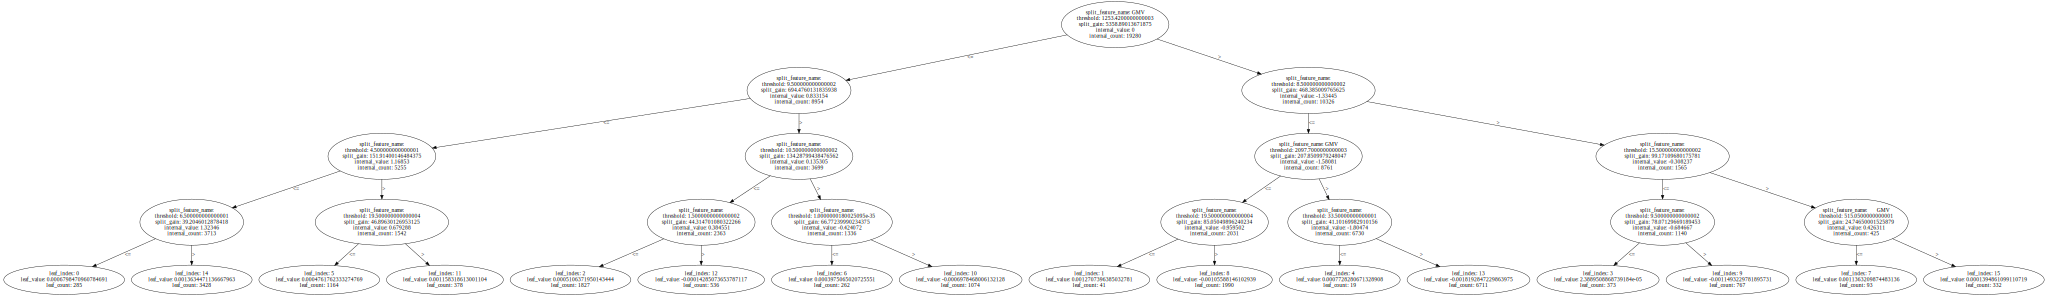

In [54]:
import lightgbm as lgb

lgb.create_tree_digraph(model,tree_index=0,
                        show_info=['split_gain',
                                   'internal_value',
                                   'internal_count',
                                   'internal_weight',
                                    'leaf_count',
                                   'leaf_weight',
                                   'data_percentage'])

In [55]:
import shap

explainer = shap.TreeExplainer(model)

In [56]:
shap_values = explainer.shap_values(X)

d:\Anaconda3\lib\site-packages\shap\explainers\tree.py:195: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1], X.iloc[1])

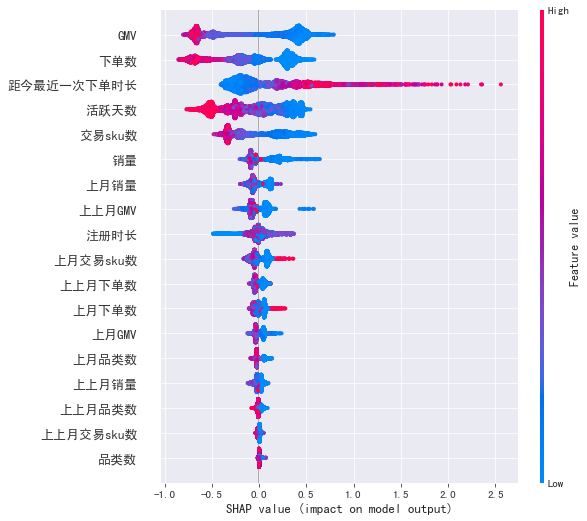

In [58]:
shap.summary_plot(shap_values[1], X)

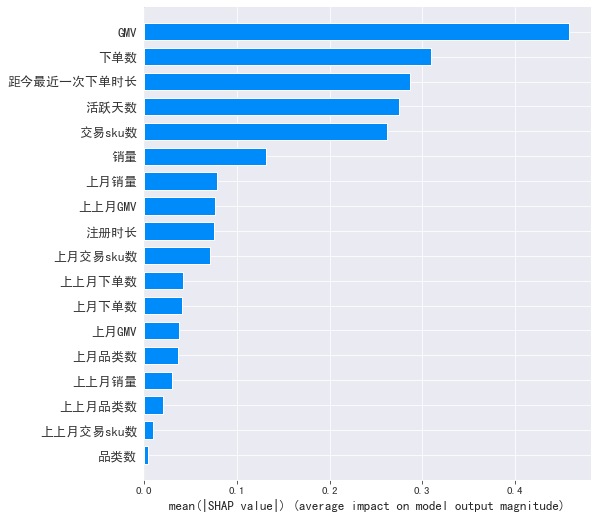

In [59]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

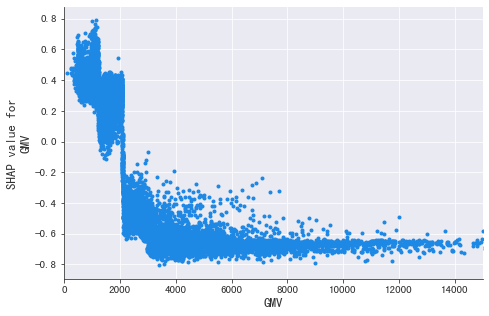

In [60]:
shap.dependence_plot('GMV', shap_values[1], X, interaction_index=None, show=False,xmin=0,xmax=15000)
plt.savefig('GMV.png',dpi=200)

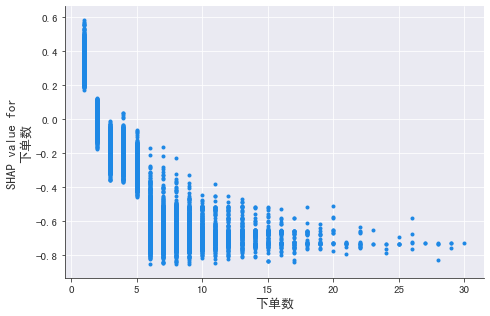

In [61]:
shap.dependence_plot('下单数', shap_values[1], X, interaction_index=None, show=False)
plt.savefig('下单数.png',dpi=200)

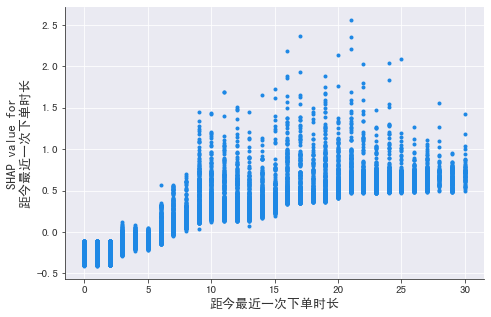

In [62]:
shap.dependence_plot('距今最近一次下单时长', shap_values[1], X, interaction_index=None, show=False)
plt.savefig('距今最近一次下单时长.png',dpi=200)

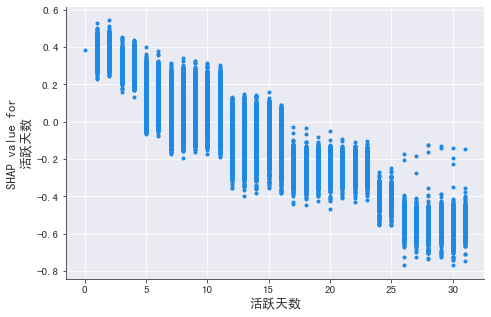

In [63]:
shap.dependence_plot('活跃天数', shap_values[1], X, interaction_index=None, show=False)
plt.savefig('活跃天数.png',dpi=200)

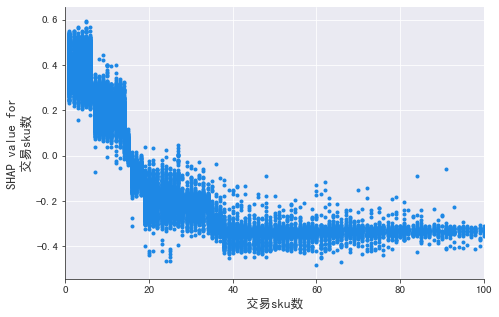

In [64]:
shap.dependence_plot('交易sku数', shap_values[1], X, interaction_index=None, show=False,xmin=0,xmax=100)
plt.savefig('交易sku数.png',dpi=200)